TP1 - Recalage d'images
=============

In [1]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [2]:
def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g

In [3]:
f,g=get_images()

# 1. Formalisation du problème

1.1 Formalisme continu
---------------------

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

> Problème inverse $(P_1)$ : 

> Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

> $(P_2)$ On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du bruit par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations \ de \ volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$

Q1. A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$\langle \nabla E(u),h\rangle = \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

Pour déterminer le gradient $\nabla E$, on ajoute une petite variation $h$ au paramètre $u$ :

$$\begin{align}
E(u+h) &= \frac{1}{2}\int_{\Omega} \left( f(x+u(x)+h(x)) - g(x)\right)^2 dx \\
&= \frac{1}{2} \int_{\Omega} \left(f(x+u(x)) + \langle \nabla f(x+u(x)), h(x) \rangle - g(x) + o(\|h\|) \right)^2 dx \\
&= \frac{1}{2} \int_{\Omega} \left(f(x+u(x)) - g(x)\right)^2 + 2 \langle \nabla f(x+u(x)), h(x) \rangle \left( f(x+u(x)) - g(x) \right) + o(\|h\|) \, dx \\
&= E(u) + \int_{\Omega} \langle \underbrace{\left( f(x + u(x)) - g(x) \right) \nabla f(x + u(x))}_{\nabla E(u)}, h(x) \rangle \, dx + o(\|h\|)
\end{align}$$


On obtient alors $\nabla E(u) = \left( f(id + u) -g \right) \nabla f(id +u)$.

# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathbb{R}^n\times \mathbb{R}^m$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$
défini sur $\mathbb{R}^n\times \mathbb{R}^m$. 

2.1. Calcul du $E$ et de son gradient
-----------------------------------

Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est ce que fait la fonciton interpol ci-dessous.

In [4]:
def interpol(f,ux,uy) :
    """function that computes f \circ Id+u and interpolates it on a mesh"""
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

2.2. Calcul de $R$ et de son gradient
-------------------------------------
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par:
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases} $$

On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2_{i} + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2_{i}.
$$ 
où:
* $u_x\in\mathbb{R}^n$ et $u_y\in\mathbb{R}^n$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie et $\partial_x:\mathbb{R}^n\rightarrow\mathbb{R}^n$
* $\partial_y:\mathbb{R}^n\rightarrow\mathbb{R}^n$ représentent des opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle.
$$

Q2. Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après.

Pour le discrétisation de l'opérateur $\partial_y$, on reprend celle de $\partial_x$ en changeant l'axe sur lequel on effectue les différences :
$$\partial _y f=
\begin{cases}
\begin{align}
f_{i,j+1}-f_{ij} & \text{ si } j < n \\
        0\phantom{00000000} & \text{ si } j=n
\end{align}
\end{cases} $$

Pour trouver $\partial_x^\top \text{ et } \partial_y^\top$, on retrouve par identification les valeurs de la deuxième variable des produits scalaires respectifs : $\langle \partial_x u, v \rangle \text{ et } \langle \partial_y u, v \rangle $ 

$$\begin{align}
\langle \partial _x u, v \rangle &= \sum_{i=1}^{n-1}\sum_{j=1}^{n}(u_{i+1,j}-u_{i,j})v_{i,j}\\
&=\sum_{i=1}^{n-1}\sum_{j=1}^{n}u_{i+1,j}v_{i,j}-\sum_{i=1}^{n-1}\sum_{j=1}^{n}u_{i,j}v_{i,j}\\
&=\sum_{i=2}^{n}\sum_{j=1}^{n}u_{i,j}v_{i-1,j}-\sum_{i=1}^{n-1}\sum_{j=1}^{n}u_{i,j}v_{i,j}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{n}u_{i,j}v_{i-1,j}-\sum_{i=2}^{n-1}\sum_{j=1}^{n}u_{i,j}v_{i,j} - \sum_{j=1}^{n} u_{1,j}v_{1,j} + \sum_{j=1}^{n} u_{n,j}v_{n-1,j}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{n}u_{i,j}\underbrace{(v_{i-1,j}-v_{i,j})}_{\partial_x^\top v_{2\cdots n-1, j}} + \sum_{j=1}^{n} u_{n,j}\underbrace{v_{n-1,j}}_{\partial_x^\top v_{n, j}} \underbrace{- v_{1,j}}_{\partial_x^\top v_{1, j}} u_{1,j}\\
\end{align}$$

On obtient alors pour $\partial_x^\top$ :
$$ \partial_x^\top f = \begin{cases} \begin{align}
-f_{1,j} & \text{ si } i=1 \\
f_{i-1,j}-f_{i,j} & \text{ si } i \geq 2  \text{ et } i \leq n-1 \\
        f_{n-1,j} & \text{ si } i=n \\
\end{align} \end{cases}$$

De même pour $\partial_y^\top$ en changeant l'axe :
$$ \partial_y^\top f = \begin{cases} \begin{align}
-f_{i,1} & \text{ si } j=1 \\
f_{i,j-1}-f_{i,j} & \text{ si } j \geq 2  \text{ et } j \leq n-1 \\
        f_{i,n-1} & \text{ si } j=n       
\end{align} \end{cases}$$

In [5]:
def dx(im) :
    d = np.zeros_like(im)
    d[:-1,:] = im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d = np.zeros_like(im)
    d[:,:-1] = im[:,1:]-im[:,:-1]
    return d
def dxT(im) :
    d = np.zeros_like(im)
    d[0,:] = -im[0,:]
    d[1:-1,:] = im[:-2,:] - im[1:-1,:]
    d[-1,:] = im[-2,:]
    return d
def dyT(im) :
    d = np.zeros_like(im)
    # To be implemented
    d[:,0] = -im[:,0]
    d[:,1:-1] = im[:,:-2] - im[:,1:-1]
    d[:,-1] = im[:,-2]
    return d  

Q3. On écrit $R(u)$ comme un opérateur de $V^2$ dans $\mathbb{R}$. Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$
et donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.

On peut ré-écrire $$R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u) \\
R_1(u)=\frac{1}{2}\langle A_1 u , A_1 u\rangle \qquad R_2(u) = \frac{1}{2}\langle A_2 u , A_2 u\rangle.
$$

Pour $R_1$, on peut déterminer la valeur de $A_1$ :
$$
R_1(u) = \|A_1u\|^2_{V^2} = \left\| A_1 \left( \begin{array}{c} u_x \\ u_y \end{array}\right) \right\|^2_{V^2}
$$
Or par identification : 
$$
\|A_1u\|^2 = \mu \|\partial_x u_y + \partial_y u_x \|^2 \\
A_1 = \sqrt{\mu} \left( \begin{array}{c} \partial_y & \partial_x \end{array} \right)
$$

De même pour $R_2$, on peut déterminer la valeur de $A_2$ :
$$
R_2(u) = \|A_2u\|^2_{V^2} = \left\| A_2 \left( \begin{array}{c} u_x \\ u_y \end{array}\right) \right\|^2_{V^2}
$$
Or par identification : 
$$
\|A_2u\|^2 = (\lambda + \mu) \|\partial_x u_x + \partial_y u_y \|^2 \\
A_1 = \sqrt{\lambda + \mu} \left( \begin{array}{c} \partial_x & \partial_y \end{array} \right)
$$

Q4. Donner l'expression du gradient de $R$.

On a $R(u) = \frac{1}{2}R_1(u) + \frac{1}{2}R_2(u)$ donc par linéarité, $\nabla R(u) = \frac{1}{2}\nabla R_1(u) + \frac{1}{2}\nabla R_2(u)$

En calculant séparement $\nabla R_1(u)$ et $\nabla R_2(u)$, on en déduit que :

$$\begin{align}
\nabla R_1(u) &= 2 A_1^\top A_1 u = 2\mu \left(\begin{array}{c}
\partial_y^\top\\
\partial_x^\top
\end{array}\right) \left(\begin{array}{c}
\partial_y & \partial_x
\end{array}\right) \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2\mu \left(\begin{array}{c}\partial_y^\top \partial_y u_x + \partial_y^\top \partial_xu_y\\ \partial_x^\top \partial_y u_x +  \partial_x^\top \partial_x u_y\end{array}\right)
\end{align}$$

$$\begin{align}
\nabla R_2(u) &= 2 A_2^\top A_2 u = 2(\lambda + \mu) \left(\begin{array}{c}
\partial_x^\top\\
\partial_y^\top
\end{array}\right) \left(\begin{array}{c}
\partial_x & \partial_y
\end{array}\right) \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2(\lambda + \mu) \left(\begin{array}{c}\partial_x^\top \partial_x u_x + \partial_x^\top \partial_y u_y\\ \partial_y^\top \partial_x u_x +  \partial_y^\top \partial_y u_y\end{array}\right)
\end{align}$$

On obtient bien alors le résultat suivant :
$$
\begin{align}
\nabla R(u) &= \frac{1}{2}\nabla R_1(u) + \frac{1}{2}\nabla R_2(u) \\
&= 
\mu \left(\begin{array}{c}\partial_y^\top \partial_y u_x + \partial_y^\top \partial_xu_y\\ \partial_x^\top \partial_y u_x +  \partial_x^\top \partial_x u_y\end{array}\right)
+
(\lambda + \mu) \left(\begin{array}{c}\partial_x^\top \partial_x u_x + \partial_x^\top \partial_y u_y\\ \partial_y^\top \partial_x u_x +  \partial_y^\top \partial_y u_y\end{array}\right)
\end{align}
$$

2.3. Implémentation de la fonction objectif $E+R$
----------------------------------------------

In [6]:
def objective_function(f,g,ux,uy,lamb,mu):
    fu = interpol(f, ux, uy)
    
    E = (1/2) * npl.norm(fu - g)**2
        
    R = mu/2 * npl.norm(dx(uy) + dy(ux))**2 + (lamb+mu)/2 * npl.norm(dx(ux) + dy(uy))**2
    
    return E + R,fu

# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

Q5. Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [7]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

In [40]:
def RecalageDG(f,g,lamb,mu,nitermax,stepini=0.1, modulo=5, plot=True) : 
    ux=np.zeros_like(f)
    uy=np.zeros_like(f)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    
    dfx = dx(f)
    dfy = dy(f)
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   
        # Gradient of E at point u
        gradfuX = interpol(dfx, ux, uy)
        gradfuY = interpol(dfy, ux, uy)        
        
        gradEx = (fu - g) * gradfuX
        gradEy = (fu - g) * gradfuY
        
        #fu = interpol(f, ux, uy)
        #gradfuX = dx(fu)
        #gradfuY = dy(fu)
        
        #gradEx = (fu - g) * gradfuX
        #gradEy = (fu - g) * gradfuY
        
        # Gradient of R at point u
        gradRx = mu * (dyT(dy(ux)) + dyT(dx(uy))) + (mu+lamb) * (dxT(dx(ux)) + dxT(dy(uy)))
        gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (mu+lamb) * (dyT(dx(ux)) + dyT(dy(uy)))
        
        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (plot and niter % modulo ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list), niter

Q5. Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [47]:
def find_mins(lamb_range, mu_range, nb_points=10, 
              nitermax=4000, modulo=10, plot=True):
    values_lamb = np.linspace(lamb_range[0], lamb_range[1], nb_points)
    values_mu = np.linspace(mu_range[0], mu_range[1], nb_points)
    
    niters = np.zeros(nb_points)
    CFs = []
    
    step0 = 0.1
    print(values_lamb.shape)
    print(values_mu.shape)
    print(values_lamb[1])
    
    
    for i in range(nb_points):
        ux, uy, CF, step, niters[i] = RecalageDG(f, g, values_lamb[i],
                                                 values_mu[i], nitermax,
                                                 step0, modulo, plot)
        CFs.append(CF)
        
    return values_lamb, values_mu, CFs, niters

In [50]:
def find_plot(lamb_range, mu_range, nb_points=10, nitermax=4000, modulo=10, plot=True):
    lambs, mus, CFs, niters = find_mins(lamb_range, mu_range, nb_points, nitermax, modulo, plot)
    
    plt.figure()
    plt.semilogy(lambs, niters, label="lambs")
    plt.plot()
    
    plt.figure()
    plt.semilogy(mus, niters, label="mus")
    plt.plot()
    
    print(niters)
    print(CFs)

(20,)
(20,)
-0.868421052631579
iteration : 100  cost function : nan step : 1.2676506002282295e+29


/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract
/h

iteration : 200  cost function : nan step : 1.6069380442589904e+59
iteration : 300  cost function : nan step : 2.0370359763344862e+89
iteration : 400  cost function : nan step : 2.5822498780869087e+119
iteration : 500  cost function : nan step : 3.273390607896142e+149


/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in add


iteration : 100  cost function : nan step : 1.2676506002282295e+29
iteration : 200  cost function : nan step : 1.6069380442589904e+59
iteration : 300  cost function : nan step : 2.0370359763344862e+89
iteration : 400  cost function : nan step : 2.5822498780869087e+119
iteration : 500  cost function : nan step : 3.273390607896142e+149
iteration : 100  cost function : nan step : 1.2676506002282295e+29


/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in subtract
  import sys
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in add
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in subtract
  if sys.path[0] == '':
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in subtract


iteration : 200  cost function : nan step : 1.6069380442589904e+59
iteration : 300  cost function : nan step : 2.0370359763344862e+89
iteration : 400  cost function : nan step : 2.5822498780869087e+119
iteration : 500  cost function : nan step : 3.273390607896142e+149
iteration : 100  cost function : nan step : 1.2676506002282295e+29
iteration : 200  cost function : nan step : 1.6069380442589904e+59
iteration : 300  cost function : nan step : 2.0370359763344862e+89
iteration : 400  cost function : nan step : 2.5822498780869087e+119
iteration : 500  cost function : nan step : 3.273390607896142e+149
iteration : 100  cost function : nan step : 1.2676506002282295e+29
iteration : 200  cost function : nan step : 1.6069380442589904e+59
iteration : 300  cost function : nan step : 2.0370359763344862e+89
iteration : 400  cost function : nan step : 2.5822498780869087e+119
iteration : 500  cost function : nan step : 3.273390607896142e+149


/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in add
  
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in add
/home/pjbenard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in add


iteration : 100  cost function : nan step : 1.2676506002282295e+29
iteration : 200  cost function : nan step : 1.6069380442589904e+59
iteration : 300  cost function : nan step : 2.0370359763344862e+89
iteration : 400  cost function : nan step : 2.5822498780869087e+119
iteration : 500  cost function : nan step : 3.273390607896142e+149
iteration : 100  cost function : nan step : 1.2676506002282295e+29
iteration : 200  cost function : nan step : 1.6069380442589904e+59
iteration : 300  cost function : nan step : 2.0370359763344862e+89
iteration : 400  cost function : nan step : 2.5822498780869087e+119
iteration : 500  cost function : nan step : 3.273390607896142e+149
iteration : 100  cost function : nan step : 1.2676506002282295e+29
iteration : 200  cost function : nan step : 1.6069380442589904e+59
iteration : 300  cost function : nan step : 2.0370359763344862e+89
iteration : 400  cost function : nan step : 2.5822498780869087e+119
iteration : 500  cost function : nan step : 3.2733906078961

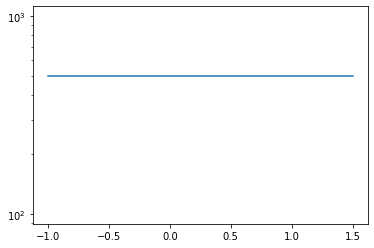

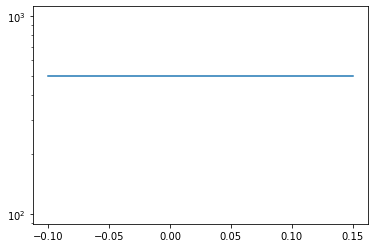

In [53]:
find_plot([-1, 1.5], [-0.1, 0.15], nb_points=20, nitermax=500, modulo=100, plot=True)

In [18]:
#lamb=10
#mu=20
lamb=0.11
mu=0.011

nitermax=5000

step0 = 0.01
ux,uy,CF,step=RecalageDG(f,g,lamb,mu,nitermax,step0)

iteration : 5  cost function : 18.86554318127195 step : 0.32
iteration : 10  cost function : 13.178352319983949 step : 10.24
iteration : 15  cost function : 5.913915028527027 step : 2.56
iteration : 20  cost function : 5.042404382019825 step : 2.56
iteration : 25  cost function : 4.420569638466155 step : 2.56
iteration : 30  cost function : 3.8893599748989773 step : 2.56
iteration : 35  cost function : 3.4703061963139636 step : 1.28
iteration : 40  cost function : 3.069241327554445 step : 2.56
iteration : 45  cost function : 2.821268029139351 step : 1.28
iteration : 50  cost function : 2.4842014436728843 step : 2.56
iteration : 55  cost function : 2.2389230440115875 step : 2.56
iteration : 60  cost function : 2.0798464811261823 step : 1.28
iteration : 65  cost function : 1.8694326759416289 step : 2.56
iteration : 70  cost function : 1.7124897270617558 step : 2.56
iteration : 75  cost function : 1.583570139011905 step : 2.56
iteration : 80  cost function : 1.475767147255132 step : 1.28


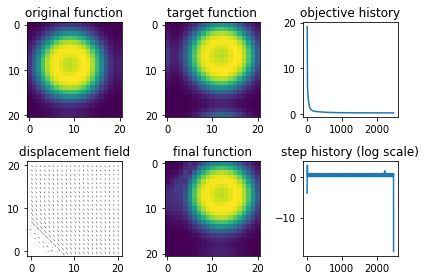

In [19]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

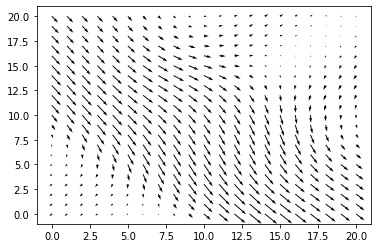

In [11]:
plt.quiver(ux, uy)
plt.show()

# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\mbox{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

Q6. Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

$$J_\psi(u)=\begin{pmatrix} 
\nabla \Psi_1(u)^\top \\ 
\nabla \Psi_2(u)^\top \\
\nabla \Psi_3(u)^\top
\end{pmatrix}$$
On determine alors les $\nabla \Psi_i(u)$ :
$$\begin{align}
\nabla \Psi_1(u)&=(J_{\Psi_1}(u))^\top \\
J_{\Psi_1}(u)&=J_f(h(u)) \times J_h(u)  \quad  \text{ avec } h(u)=Id+u\\
&=\nabla^\top f(h(u)) \times Id \\
&=\nabla^\top f(h(u)) = \nabla^\top f(Id + u)\\
\nabla _{\Psi_2}(u)&=\sqrt{\mu} \, \nabla (\partial_x u_y + \partial_y u_x)\\
&=\sqrt{\mu} \begin{pmatrix} 
\partial_x  \\
\partial_y  \\
\end{pmatrix}\\
\nabla _{\Psi_3}(u)&=\sqrt{\lambda +\mu} \, \nabla (\partial_x u_x + \partial_y u_y)\\
&=\sqrt{\lambda + \mu} \begin{pmatrix} 
\partial_x  \\
\partial_y  \\
\end{pmatrix}
\end{align}$$

Donc, 
$$\begin{align}
J_{\Psi}(u) \begin{pmatrix}
v_x \\
v_y\\
\end{pmatrix} = \begin{pmatrix}
df_x(Id+u)v_x + df_y (Id+u) v_y \\
\sqrt{\mu}\,\partial _x v_x +\sqrt{\mu}\,\partial_y v_y \\
\sqrt{\lambda + \mu}\,\partial_x v_x + \sqrt{\lambda +\mu}\,\partial_y v_y \\
\end{pmatrix}
\end{align}$$

Q7. Implémenter les fonctions JPsi, JTPsi et JTJ qui calculent respectivement:
- le produit de $J_\psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.

In [12]:
def JTPsi(phi,df,lamb,mu) :
    ux = df[0]*phi[0] + np.sqrt(mu) * dyT(phi[1]) + np.sqrt(mu + lamb) * dxT(phi[2])
    uy = df[1]*phi[0] + np.sqrt(mu) * dxT(phi[1]) + np.sqrt(mu + lamb) * dyT(phi[2])
    return [ux,uy]
  
def JPsi(vx,vy,df,lamb,mu) :    
    JPsi0 = df[0] * vx + df[1] * vy
    JPsi1 = np.sqrt(mu) * (dy(vx) + dx(vy))
    JPsi2 = np.sqrt(mu + lamb) * (dx(vx) + dy(vy))
    
    return [JPsi0,JPsi1,JPsi2]
  
def JTJ(vx,vy,df,lamb,mu,epsilon) :
    phi = JPsi(vx, vy, df, lamb, mu)
    ux, uy = JTPsi(phi, df, lamb, mu)
    uxs, uys = ux + epsilon*vx, uy + epsilon*vy
    
    return uxs,uys

Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$H_k = (J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [13]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

Q8. Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [25]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx, dfy = dx(f), dy(f)
    df = [dfx, dfy]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfxu = interpol(dfx, ux, uy)
        dfyu = interpol(dfy, ux, uy)
        dfu = [dfxu, dfyu]        
        
        psi0 = fu - g        
        psi1 = np.sqrt(mu) * (dx(uy) + dy(ux))
        psi2 = np.sqrt(mu+lamb) * (dx(ux) + dy(uy))
        Psi = [psi0, psi1, psi2]
        b = JTPsi(Psi, dfu, lamb, mu)
          
        #ux, uy = CGSolve(ux, uy, lamb, mu, b, epsi, [dx(f), dy(f)])
        df = [dx(f), dy(f)]
        
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 10 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
            
        if (niter % 50 ==0):
            fig, ax = plt.subplots(2,3)
            ax[0,0].imshow(f)
            ax[0,0].set_title('original function')
            ax[0,1].imshow(g)
            ax[0,1].set_title('target function')
            ax[1,0].quiver(ux,uy)
            ax[1,0].set_title('displacement field')
            ax[1,1].imshow(interpol(f,ux,uy))
            ax[1,1].set_title('final function')
            ax[0,2].plot(CF)
            ax[0,2].set_title('objective history')
            ax[1,2].plot(np.log(step))
            ax[1,2].set_title('step history (log scale)')

            plt.tight_layout()
            plt.show()
            
    return ux,uy,np.array(CF),np.array(step_list)

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [15]:
epsi=0.1
nitermax=1000
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 18.98619391902075 step : 0.08
iteration : 6  cost function : 17.824018064473375 step : 0.64
iteration : 9  cost function : 10.572898540330744 step : 5.12
iteration : 12  cost function : 1.6458458560996077 step : 1.28
iteration : 15  cost function : 0.8307311187990158 step : 1.28
iteration : 18  cost function : 0.5166658934741727 step : 1.28
iteration : 21  cost function : 0.37429916599976604 step : 1.28
iteration : 24  cost function : 0.30960933629495485 step : 2.56
iteration : 27  cost function : 0.2782629900140218 step : 2.56
iteration : 30  cost function : 0.2635813999881079 step : 2.56
iteration : 33  cost function : 0.25623067933625576 step : 2.56
iteration : 36  cost function : 0.25278098370093166 step : 2.56
iteration : 39  cost function : 0.25102932010785467 step : 2.56
iteration : 42  cost function : 0.2502539702697351 step : 2.56
iteration : 45  cost function : 0.24988730465717895 step : 2.56
iteration : 48  cost function : 0.24975964869111128 s

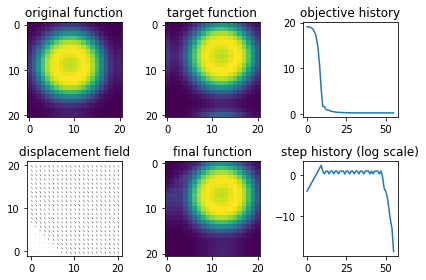

In [16]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

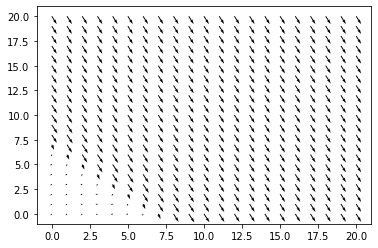

In [17]:
plt.quiver(ux, uy)
plt.show()

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

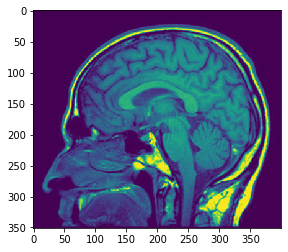

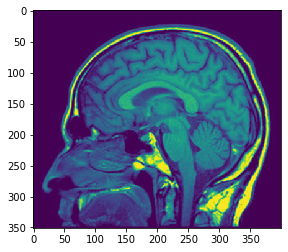

In [22]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [23]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

iteration : 10  cost function : 0.1437494115650293 step : 10.24
iteration : 20  cost function : 0.14367104623791402 step : 1.28
iteration : 30  cost function : 0.1436081342993295 step : 2.56
iteration : 40  cost function : 0.1435642109171876 step : 1.28
iteration : 50  cost function : 0.1435119527649336 step : 2.56


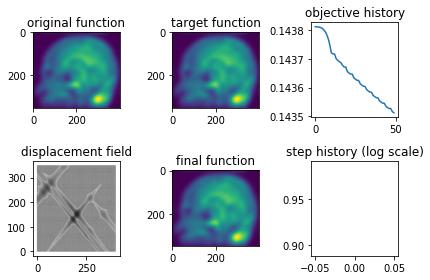

iteration : 60  cost function : 0.1434671631943765 step : 2.56
iteration : 70  cost function : 0.14342479698466365 step : 2.56
iteration : 80  cost function : 0.14338289586985767 step : 2.56
iteration : 90  cost function : 0.143344660856882 step : 1.28
iteration : 100  cost function : 0.14330458555583686 step : 2.56


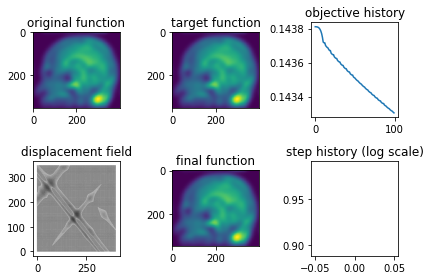

iteration : 110  cost function : 0.1432706631376491 step : 1.28
iteration : 120  cost function : 0.14323134126080267 step : 2.56
iteration : 130  cost function : 0.14319615664731347 step : 2.56
iteration : 140  cost function : 0.14316261372195635 step : 2.56
iteration : 150  cost function : 0.1431286655512561 step : 2.56


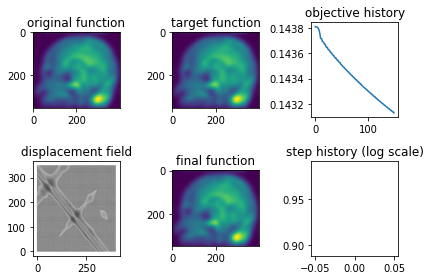

iteration : 160  cost function : 0.14309812166972224 step : 1.28
iteration : 170  cost function : 0.14306477510467397 step : 2.56
iteration : 180  cost function : 0.14303786455635875 step : 1.28
iteration : 190  cost function : 0.14300421737010813 step : 2.56
iteration : 200  cost function : 0.1429745581716395 step : 2.56


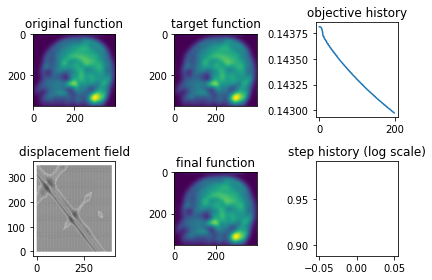

iteration : 210  cost function : 0.1429468592101433 step : 2.56
iteration : 220  cost function : 0.1429177571336065 step : 2.56
iteration : 230  cost function : 0.14289273766102414 step : 1.28
iteration : 240  cost function : 0.14286356643607553 step : 2.56
iteration : 250  cost function : 0.14283718959014408 step : 2.56


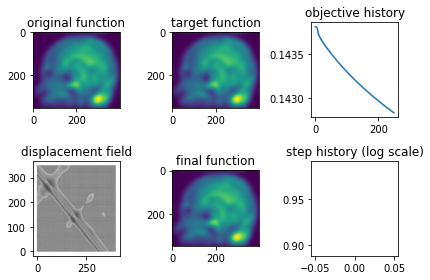

iteration : 260  cost function : 0.14281190599416185 step : 2.56
iteration : 270  cost function : 0.14278605552941975 step : 2.56
iteration : 280  cost function : 0.1427628105553881 step : 1.28
iteration : 290  cost function : 0.142737039265743 step : 2.56
iteration : 300  cost function : 0.1427132904327322 step : 2.56


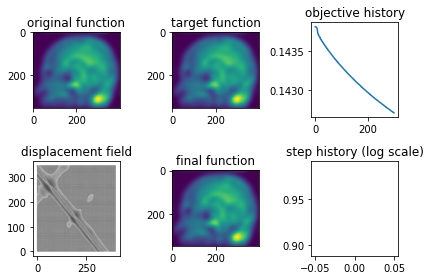

iteration : 310  cost function : 0.1426900844242309 step : 2.56
iteration : 320  cost function : 0.14266683222933238 step : 2.56
iteration : 330  cost function : 0.14264521571668057 step : 1.28
iteration : 340  cost function : 0.14262213497640894 step : 2.56
iteration : 350  cost function : 0.14260258571051274 step : 1.28


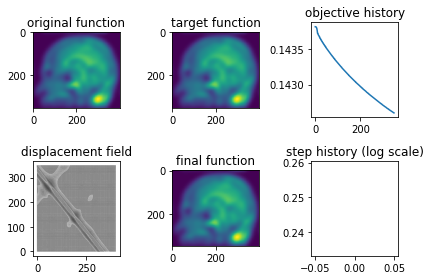

iteration : 360  cost function : 0.14257915476983987 step : 2.56
iteration : 370  cost function : 0.14255803949018378 step : 2.56
iteration : 380  cost function : 0.14253790630184318 step : 2.56
iteration : 390  cost function : 0.14251701787304455 step : 2.56
iteration : 400  cost function : 0.14249849787167618 step : 1.28


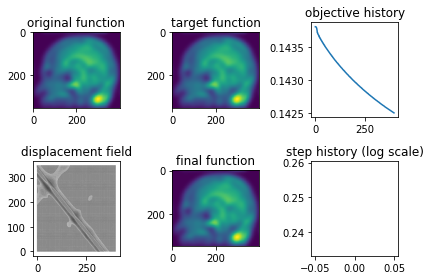

iteration : 410  cost function : 0.14247745187870428 step : 2.56
iteration : 420  cost function : 0.1424581325774974 step : 2.56
iteration : 430  cost function : 0.14243934801490354 step : 2.56
iteration : 440  cost function : 0.14242028661796144 step : 2.56
iteration : 450  cost function : 0.14240278193661113 step : 1.28


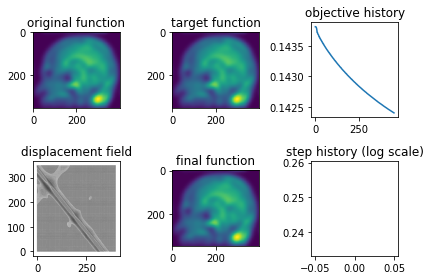

iteration : 460  cost function : 0.14238369271680984 step : 2.56
iteration : 470  cost function : 0.1423679456388591 step : 1.28
iteration : 480  cost function : 0.14234835122428563 step : 2.56
iteration : 490  cost function : 0.14233084029437548 step : 2.56
iteration : 500  cost function : 0.14231431388679577 step : 2.56


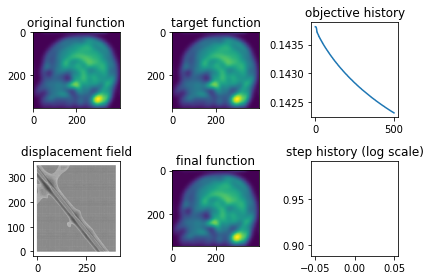

In [26]:
epsi=0.1
nitermax=500
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

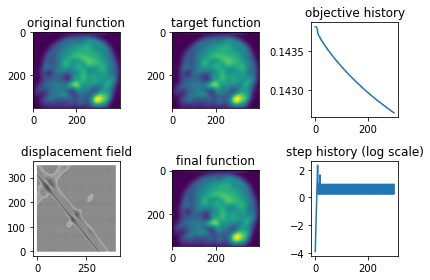

In [122]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

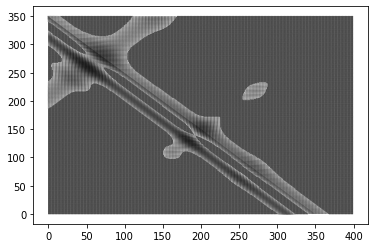

In [123]:
plt.quiver(ux, uy)
plt.show()

In [27]:
epsi=0.1
nitermax=300
lamb = 1/9
ux,uy,CF,step=RecalageDG(f,g,lamb,mu,nitermax,step0)

iteration : 5  cost function : 0.14380979819288944 step : 0.32
iteration : 10  cost function : 0.14380835303204564 step : 0.02
iteration : 15  cost function : 0.14380805380684314 step : 0.005
iteration : 20  cost function : 0.14380795921826253 step : 0.005
iteration : 25  cost function : 0.1438078703813999 step : 0.005
iteration : 30  cost function : 0.14380778340516226 step : 0.005
iteration : 35  cost function : 0.1438076978062016 step : 0.005
iteration : 40  cost function : 0.1438076133782425 step : 0.005
iteration : 45  cost function : 0.14380753000913649 step : 0.005
iteration : 50  cost function : 0.1438074476276746 step : 0.005
iteration : 55  cost function : 0.14380736618386739 step : 0.005
iteration : 60  cost function : 0.14380728564013534 step : 0.005
iteration : 65  cost function : 0.14380720596714291 step : 0.005
iteration : 70  cost function : 0.1438071271415097 step : 0.005
iteration : 75  cost function : 0.14380704914461134 step : 0.005
iteration : 80  cost function : 0

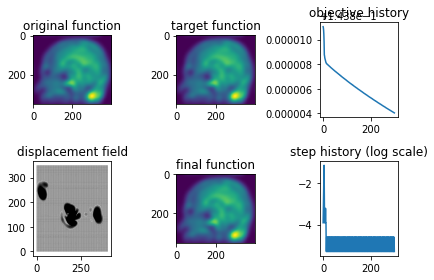

In [28]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

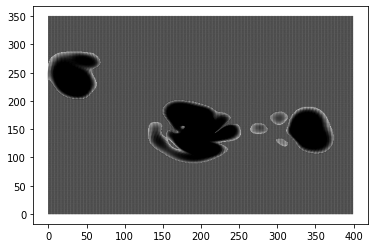

In [29]:
plt.quiver(ux, uy)
plt.show()